# Sequential Processing 

So far, we have always processed the entire received signal as a single block of samples.

In practice, samples must be processed *sequentially* as they are received.

Otherwise, 
* the receiver incurs long (or even unbounded) delay (latency),
* the ability to store samples may be exceeded.

We will investigate how we can implement receiver functions that work incrementally as blocks of one or a few samples are received.

<a href="https://colab.research.google.com/github/bepepa/digital_comms/blob/master/075_sequential_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> (Executable notebook)

<a href="https://nbviewer.org/format/slides/github/bepepa/digital_comms/blob/main/075_sequential_processing.ipynb"><img src="https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg" alt="Render nbviewer" /> </a> (read-only, slides view)

In [1]:
## Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns_context = "notebook"
sns.set_theme(context=sns_context, style="ticks")


In [ ]:
## import needed functions from the comms library
from comms.sources import random_symbols
from comms.pulse_shaping import srrc_pulse, pulse_shape
from comms.sequences import lfsr

## Make a test signal

For testing, we construct a signal that consists of:
* two consecutive bursts, separated by an idle period
* Each burst contains:
  + a preamble with known training sequence
    - of length $K=31$ BPSK symbols
    - it is an order-5 M-sequence with feedback `fb=5`
  + a payload that contains
    - 128 QPSK symbols

In [7]:
## Transmitter
# make L bursts containing preamble and payloads
# Parameters
fsT = 32    # tx oversampling
K = 31      # length of preamble
Ns = 128    # length of payload
fb = 5      # LFSR feedback
L = 2       # number of bursts to generate

Ap = np.array([1.0, -1.0], dtype=complex) # BPSK for preamble
A = np.exp(1j*np.pi/4*np.arange(1, 8, 2)) # QPSK for payload

hh = srrc_pulse(0.5, fsT)    # pulse shape

# make a single preamble ...
pn = Ap[lfsr(1, fb, K, 5)]
# ... and L distinct payloads
syms = np.zeros((L, Ns), dtype=complex)
for n in range(L):
    syms[n, :] = random_symbols(A, Ns)

# generate the L pulse shaped bursts
N_burst = (K + Ns) * fsT + len(hh) - fsT   # length of pulse shaped signals
sigs = np.zeros((L, N_burst), dtype=complex)
for n in range(L):
    sigs[n,:] = pulse_shape(np.concatenate((pn, syms[n,:])), hh, fsT)

In [52]:
## Channel
# channel parameters
ds_factor = 4       # down-sample by 4

# one set of parameters for each burst
delay_samples = np.array([102, 145])
# frequency offset per symbol period, phase change is +/- 0.1*2*pi over course of preamble
df = 0.1/(fsT*(K-1)) * np.array([1, -1])
# amplitude and phase
X = 0.5*np.exp(1j*np.pi/4) * np.array([1, 1j])

# construct the noise-free received signal; concatenate zeros and sigs
rr = np.concatenate(( np.zeros(delay_samples[0]), 
                     X[0] * sigs[0,:] * np.exp(2j * np.pi * df[0] * np.arange(sigs.shape[1])) ))

for n in range(1, L):
    rr = np.concatenate((rr, 
                         np.zeros(delay_samples[n]), 
                         X[n] * sigs[n,:] * np.exp(2j * np.pi * df[n] * np.arange(sigs.shape[1])) ))

# append a few more zero samples, just so that the signal doesn't end on a signal boundary
rr = np.concatenate((rr, np.zeros(23)))

# down-sample
rr = rr[::ds_factor]
fsT_r = fsT // ds_factor

SNR_dB = 20
SNR = 10**(SNR_dB/10)
noise_var = abs(X[0])**2 / SNR 

# the down-sampled signal should have higher amplitude  
rr = (np.sqrt(ds_factor)*rr + 
      np.sqrt(0.5 * noise_var) * (np.random.randn(len(rr)) + 1j*np.random.randn(len(rr))))

Let's look at the signal in time and frequency domains to make sure that it looks good.

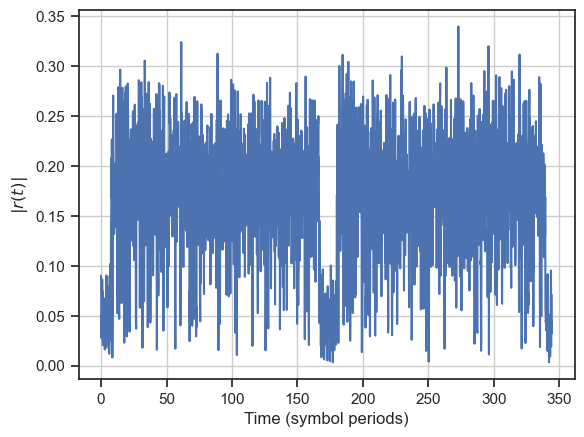

In [53]:
## time domain plot
plt.plot(np.arange(len(rr))/fsT_r, np.abs(rr))

plt.xlabel('Time (symbol periods)')
plt.ylabel('$|r(t)|$')
plt.grid()

plt.show()

There are two distinct burst, each spanning approximately 160 symbol periods.

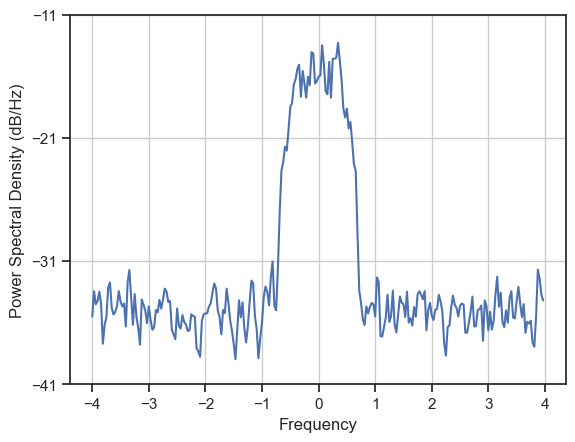

In [54]:
plt.psd(rr, Fs=fsT_r)

plt.show()

The signal occupies between $1/8$ and $1/4$ of the observed band. That is correct as the signal is $8$ times oversampled and the roll-of factor of the filter is 0.5 (50%). 

## Sequential processing

Our goal is to process the signal `rr` in small blocks - possibly as small as a single sample. That is trivial when the operation to be performed is *stateless* or *pure*. 

### Pure functions
Pure functions have no *side-effects*; given the same input, they always produce the same output.

An example of a pure function is the absolute value of each sample. We can easily write a function that computes the expected value.

In [55]:
def my_abs(sig):
    "compute the absolute value of each sample"
    # we could do a loop here, but this is easier
    return np.abs(sig)

We can use this function to process the signal `rr` sequentially one sample at a time:

In [56]:
out = np.zeros_like(rr, dtype=float)
for n in range(len(rr)):
    out[n] = my_abs(rr[n])

### Stateful functions

In contrast to pure functions, *stateful* functions depend on something beyond the input signal. Often, this is a prior input or output. But, it may also be the state of a finite-state machine that controls how a system works.

#### Computing the maximum of a signal sequentially

A simple example of a stateful function is computing the maximum value of the (absolute value of the) input signal. The maximum value depends on all samples, not just the current sample.

There are two ways to write a a stateful, sequential function:
1. passing state to and from the function
2. encapsulate the function in a class

We illustrate both approaches, starting with the former.

In [57]:
def my_max(sig, prior_max=-np.Infinity):
    "compute the maximum sequentially"
    tmp = np.max(np.abs(sig)) # max in this block
    
    # return the greater of prior_max and max in this block
    return max(prior_max, tmp)

We can pass a sample of `rr` at a time to `my_max`, but we **must maintain state** outside the function. the variable max_val does that. 

In [58]:
max_val = -np.Infinity

for n in range(len(rr)):
    max_val = my_max(rr[n], max_val)

assert max_val == np.max(np.abs(rr))
print('OK')

OK


The alternative to maintaining state **outside** a function is to *encapsulate* state inside an object. With this approach, we need to define a `class`.

In [59]:
class c_max():
    "compute maximum of a signal sequentially"

    def __init__(self):
        "Constructor: initially the state"
        # self refers to the object that holds the state
        self.prior_max = -np.Infinity

    def update(self, sig):
        "update the maximum using samples in sig"
        tmp = np.max(np.abs(sig)) # max in this block

        if tmp > self.prior_max:
            self.prior_max = tmp

        # optionally, we can return the max seen so far
        return self.prior_max

To use this class, we 
* first instantiate the object
* then, pass blocks of samples to the `update` method of the object
* finally, we retrieve the maximum

In [60]:
# instantiate the object, using the name of the class; this calls the constructor
obj_max = c_max()

# pass one sample at a time
for n in range(len(rr)):
    obj_max.update(rr[n])  # ignore the return value

# retrieve the maximum
max_val = obj_max.prior_max

assert max_val == np.max(np.abs(rr))
print('OK')

OK


Either method works.
* Using a function, often requires slightly less code as there is no "overhead" for writing a constructor
* Using a class, moves the state variable into the class and hides it from the main flow of the logic.

Let's turn to another example: convolution.

#### Computing convolution sequentially

Convolution is a fundamental signal processing observation. Given and input signal $x[n]$ of length $N$ and an impulse response $h[n]$ of length $M$, the result of the convolution $y[n] = x[n] \ast h[n]$ is
$$
y[n] = \sum{k=0}^{M-1} = h[k] \cdot x[n-k] \text{, for $0 \leq n < N+K-1$.}
$$

To compute the $n$-th output $y[n]$, we need the samples of the impulse response and samples of the input signal $x[n]$ for $n-M  < n \leq n$.
Put differently, to compute the $n$-th output, we need the $n$-th input as well as the $M-1$ prior inputs.

These $M-1$ prior inputs constitute the state that must be maintained by the stateful implementation. A vector holding these values is sometimes called a *shift register*.

Thus, a stateful implementation must do the following when presented with the $n$-th input $x[n]$:
1. use the state vector $\vec{s}[n] = \left[ x[n-M-1], \ldots, x[n-1] \right]$ and the new sample $x[n]$ to form the vector $\vec{x}[n]=\left[ x[n-M-1], \ldots, x[n-1], x[n] \right]$.
2. use the time-reversed (flipped) impulse response $\vec{h}=\left[ h[M-1, \ldots, h[0] \right]$, to compute the inner product $y[n] = \langle \vec{x}[n], \vec{h} \rangle $
3. update the state vector to $\vec{s}[n+1] = \left[ x[n-M-2], \ldots, x[n] \right]$, i.e., shift the contents of the shift register one position to the left (dropping the oldest sample) and insert the newest sample on the right.

Repeat the above for all input samples.


#### You do it:

Write both a function and a class to implement stateful convolution. The skeletons below should help you get started.

Use the two *Test* cells to check your work.

In [61]:
def my_convolve(xx, hh, shift_reg):
    """sequential convolution function"""
    # allocate storage for y[n]
    yy = np.zeros_like(xx)

    for n in range(len(xx)):
        pass  # <--- delete this line
        # concatenate shift_reg and sample x[n]

        # compute inner product and store in y[n]

        # update shift register

    return yy, shift_reg

In [62]:
# Test: running this cell should just print 'OK'
N = 12
xx = np.arange(N)       # input
hh = np.array([1, -3, 2])  # impulse response

sr = np.zeros(len(hh)-1) # state vector, maintained outside function
yy = np.zeros_like(xx)   # space to store output

# compute in blocks of 2
B = 2
for n in range(N//B):
    yy[B*n : B*(n+1)], sr = my_convolve(xx[B*n : B*(n+1)], hh, sr)

# check against NumPy's convolution function
expected = np.convolve(xx, hh)[:N]
assert np.allclose(yy, expected), f"got {yy}, expected {expected}"
print('OK')

AssertionError: got [0 0 0 0 0 0 0 0 0 0 0 0], expected [ 0  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]

In [63]:
class c_conv():
    "class for sequential convolution"

    def __init__(self, hh):
        "constructor"
        # store reverse of hh

        # initialize shift register
        self.sr = np.zeros(len(hh) - 1)

    def work(self, xx):
        "perform convolution"
        # allocate storage for y[n]
        yy = np.zeros_like(xx)

        for n in range(len(xx)):
            pass  # <---- delete this line
            # concatenate self.sr and newest sample

            # compute inner product

            # update state self.sr

        return yy


In [64]:
# Test: running this should just print 'OK'
# instantiate object
obj_conv = c_conv(hh)

yy = np.zeros_like(xx)   # space to store output

# compute in blocks of 2
B = 2
for n in range(N//B):
    yy[B*n : B*(n+1)] = obj_conv.work(xx[B*n : B*(n+1)])

# check against NumPy's convolution function
expected = np.convolve(xx, hh)[:N]
assert np.allclose(yy, expected), f"got {yy}, expected {expected}"
print('OK')

AssertionError: got [0 0 0 0 0 0 0 0 0 0 0 0], expected [ 0  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]

## Stateful demodulation

To recover the information symbols, we must switch back-and-forth between two states:
* **SEARCH:** look for the preamble and, once it is found, estimate delay (or start of burst), amplitude, phase, and frequency offset
* **DEMOD:** after correcting amplitude, phase, and frequency, recover the information symbols

Recall that in both states, we work on the outputs of the matched filter.


### Plan

We will need functions or classes to perform:
* matched filtering and separation of the matched filter output into sampling phases
* preamble detection, including estimation of synchronization parameters
* demodulation, including correction of amplitude, phase, and frequency
* a top-level function for the receiver that maintains state and invokes the corresponding processing function

All of these must work sequentially, i.e., accept a sequence of blocks of samples. 

### Matched filter

We have the matched filter already. We can simply use the matched filter function or class that we wrote above.

The impulse response is the time-reversed pulse shape with `fsT_r` samples per symbol period.

In [69]:
## verify the matched filter
hh = np.flip( srrc_pulse(0.5, fsT_r) )    # time-reversed pulse shape

# instantiate the matched filter
mf = c_conv(hh)

# filter in blocks of 80 (or less) samples
B = 80
yy = np.zeros_like(rr)

start = 0
end = min(start + B, len(rr))

while end < len(rr):
    yy[start:end] = mf.work(rr[start:end])
    start = end
    end = min(start + B, len(rr))


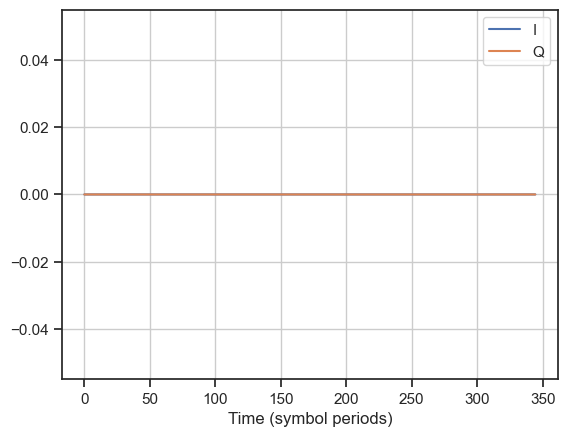

In [70]:
## plot result
tt = np.arange(len(yy))/fsT_r
plt.plot(tt, yy.real, label='I')
plt.plot(tt, yy.imag, label='Q')
plt.grid()
plt.xlabel('Time (symbol periods)')
plt.legend()

plt.show()

We can see a signal that shows the two bursts and is much "cleaner" than the received signal.

#### Extracting sample phases

As the signal is over-sampled to `fsT_r` samples per symbol, we need to be able to split the matched filter outputs into sample phases.

This entails sub-sampling the matched filter outputs by `fsT_r` with different initial offsets.

For this purpose, we write another class that 
* keeps track of the over-sampling factor
* the sampling phase for the first sample of the next/current block (this is the state variable)
* provides a method to extract a given sample phase from the input signal

In [81]:
class down_sampler():
    "stateful down-sampler"

    def __init__(self, fsT, init_phase=0):

        self.fsT = fsT
        self.phase = init_phase # phase for the first sample in block

    def work(self, sig, phase):
        "extract samples for requested phase"
        # figure out the index of the first sample for the requested phase
        offset = phase-self.phase
        if offset < 0:
            offset = phase-self.phase+self.fsT

        # down-sample starting at offset
        return sig[offset::self.fsT]
    
    def update(self, sig):
        "adjust sampling phase for next block"
        self.phase = (self.phase + len(sig)) % self.fsT

In [82]:
# signal is 0 to 7, repeated 10 times
sig = np.array([n for n in range(8)] * 10)

ds = down_sampler(8)
pp = 2                # phase to extract
B = len(sig) // 8     # block size
for n in range(8):
    yy = ds.work(sig[n*B:(n+1)*B], pp)
    ds.update(sig[n*B:(n+1)*B])
    print(f"got {yy}, ds.phase is now {ds.phase}")

got [2], ds.phase is now 2
got [2 2], ds.phase is now 4
got [2], ds.phase is now 6
got [2], ds.phase is now 0
got [2], ds.phase is now 2
got [2 2], ds.phase is now 4
got [2], ds.phase is now 6
got [2], ds.phase is now 0


### Preamble Detection

The primary task of preamble detection is to find the location of the preamble within the received signal.

For this purpose, each phase of the matched filter outputs is correlated against the preamble sequence; this is equivalent to filtering with the time-reversed, conjugate preamble sequence.

To make the comparison to a threshold independent of scale, the squared magnitudes of the correlation values are normalized by the squared norm of the samples and also the squared norm of the preamble sequence. I.e., the decision statistic at the $n$-th matched filter output is:
$$
d[n] = \dfrac{\left| \sum_{k=0}^{K-1} r[n-(K-1)+k] \cdot p^*[k] \right|^2}
             {\sum_{k=0}^{K-1} |p[k]|^2 \cdot \sum_{k=0}^{K-1} |r[n-(K-1)+k]|^2}
$$

We could use our convolution function to compute the numerator. However, the term in the denominator involving the received signal requires the same samples of the received signal. Hence, it is more efficient to write a class that takes advantage of this observation.

In [114]:
class detector():
    "compute the normalized detector statistic"

    def __init__(self, pp):
        "constructor"
        self.pp = pp                       # preamble sequence
        self.pp_2 = np.sum(np.abs(pp)**2)  # squared norm of pp
        self.sr = np.zeros_like(pp, dtype=complex)  # shift register

    def work(self, sig):
        "compute the decision statistic"
        dd = np.zeros_like(sig, dtype=float)

        for n in range(len(sig)):
            # update the shift_register
            self.sr = np.roll(self.sr, -1)  # cyclic shift to the left
            self.sr[-1] = sig[n]            # insert new sample in rightmost position

            ip = np.inner(self.sr, np.conj(self.pp))  # inner product of signal and pp
            sig_2 = np.sum(np.abs(self.sr)**2)        # squared norm of signal

            dd[n] = np.abs(ip)**2 / (self.pp_2 * sig_2)

        return dd
    
    def reset(self):
        self.sr[:] = 0

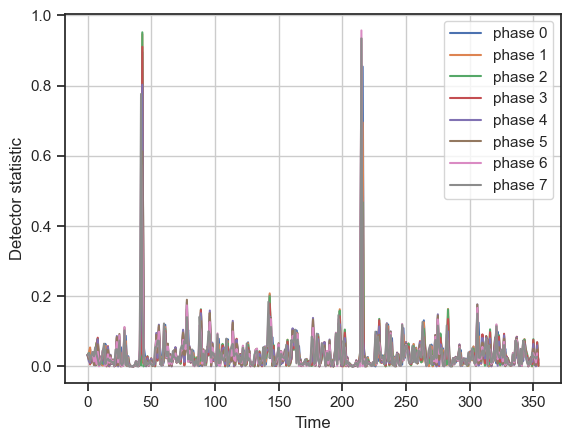

In [116]:
## compute detector statistic for all sampling phases
for pp in range(fsT_r):
    yy = np.convolve(rr, hh)[pp::fsT_r]

    det = detector(pn)
    dd = det.work(yy)

    plt.plot(dd, label=f'phase {pp}')

plt.xlabel('Time')
plt.ylabel('Detector statistic')
plt.grid()
plt.legend()

plt.show()

There are two clearly defined detection instances - one for each burst. A good threshold appears to be approximately 0.75.

### Demodulator

The demodulator takes in a block of known size of matched filter outputs. These must be amplitude, phase, and frequency corrected before modulation can be performed.

### Top-level receiver block

The top-level receiver block maintains state and coordinates which samples are passed to the appropriate processing functions.

In [118]:
SEARCH = 0
DEMOD = 1

class Receiver():
    "top-level receiver class"

    def __init__(self, hh, pp, fsT, threshold):
        self.hh = hh   # pulse shape
        self.pp = pp   # preamble sequence
        self.fsT = fsT # oversampling factor
        self.threshold = threshold

        self.state = SEARCH

        self.mf = c_conv(hh)
        self.ds = down_sampler(fsT)
        self.det = detector(pp)

        self.Np = len(pp)   # length of preamble

        # store recent matched filter outputs by sampling phase
        self.recent_mf_out = np.zeros(fsT, self.Np)
        
        # store data relevant for detection
        self.det_max = 0

    def work(self, sig):
        "main entry point"

        # compute the matched filter outputs
        yy = self.mf.work(sig)

        if self.state == SEARCH:
            pass

        if self.state == DEMOD:
            pass
